In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch.autograd
import torch
from torchvision import models, datasets, transforms
import math
from utils import blockify, deblockify, block_dct, block_idct, square_to_zigzag, get_zigzag
from tqdm import tqdm

In [2]:
def C(i):
    if i == 0:
        return 1/(2*math.sqrt(2))
    else:
        return 1/2
def getDCTCoef(size = (8,8)):
    DCT_coef = torch.zeros(size).double()
    for i in range(size[0]):
        for k in range(size[1]):
            C_i = C(i)
            DCT_coef[i,k]=C_i*math.cos((2*k+1)*i*math.pi/16)
    return DCT_coef
DCT_coef = getDCTCoef((8,8))
IDCT_coef = torch.inverse(DCT_coef)
resize224 = transforms.Resize((224, 224))
zigzag = get_zigzag()

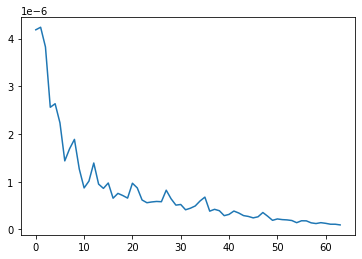

In [3]:
inputgrad = np.mean(np.abs(np.load("./grad/Cb_sen_listAlexnet.npy")),0)[None,None,:,:]
flatten_grad = square_to_zigzag(torch.tensor(inputgrad[0,0])).detach().numpy()
plt.plot(flatten_grad)

In [4]:
IDCT_coef

tensor([[ 0.3536,  0.4904,  0.4619,  0.4157,  0.3536,  0.2778,  0.1913,  0.0975],
        [ 0.3536,  0.4157,  0.1913, -0.0975, -0.3536, -0.4904, -0.4619, -0.2778],
        [ 0.3536,  0.2778, -0.1913, -0.4904, -0.3536,  0.0975,  0.4619,  0.4157],
        [ 0.3536,  0.0975, -0.4619, -0.2778,  0.3536,  0.4157, -0.1913, -0.4904],
        [ 0.3536, -0.0975, -0.4619,  0.2778,  0.3536, -0.4157, -0.1913,  0.4904],
        [ 0.3536, -0.2778, -0.1913,  0.4904, -0.3536, -0.0975,  0.4619, -0.4157],
        [ 0.3536, -0.4157,  0.1913,  0.0975, -0.3536,  0.4904, -0.4619,  0.2778],
        [ 0.3536, -0.4904,  0.4619, -0.4157,  0.3536, -0.2778,  0.1913, -0.0975]],
       dtype=torch.float64)

In [5]:
grad = np.zeros((8,8))[None,None,:]
grad[:,:,0,0] = 1
grad = grad.repeat(784,1)[None,:]
grad = grad.repeat(1,1)
grad.shape

(1, 1, 784, 8, 8)

In [86]:
img = torch.tensor(np.random.rand(1,226,226))

In [87]:
G_lst = []
for i in tqdm(range(8)):
    for j in range(8):
        grad = np.zeros((8,8))[None,None,:]
        grad[:,:,i,j] = 1
        grad = grad.repeat(784,1)[None,:]
        grad = grad.repeat(1,1)
        idx = zigzag[i,j]
        DCTblock = DCT_coef@(blockify(img[None,:], 8))@(DCT_coef.transpose(1,0))
        DCTblock.requires_grad = True
        rcvimg = deblockify(IDCT_coef@DCTblock@(IDCT_coef.transpose(1,0)),img.shape[1:])
        rszimg = resize224(rcvimg)
        DCTrszcoef = DCT_coef@blockify(rszimg, 8)@(DCT_coef.transpose(1,0))
        DCTrszcoef.backward(torch.tensor(grad))
        G = DCTblock.grad
        tmp = G[0].detach().cpu().numpy()
        G_lst.append(tmp)
G_lst = np.array(G_lst)
G_lst = G_lst[:,0,:,:]
# Jacobian = torch.tensor(np.zeros((64,G_lst.shape[1],64)))
#         Jacobian[idx]=square_to_zigzag(torch.mean(torch.abs(G),[0,2])[0]).detach().numpy()

100%|█████████████████████████████████████████████| 8/8 [00:00<00:00, 43.21it/s]


In [88]:
G_lst = np.mean(np.abs(G_lst),1)

In [89]:
G_lst.shape

(64, 8, 8)

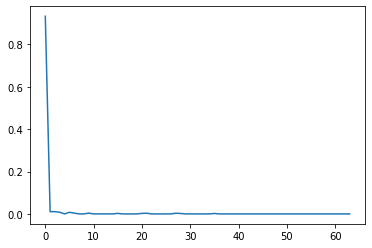

In [90]:
plt.plot(square_to_zigzag(torch.tensor(G_lst[0])))

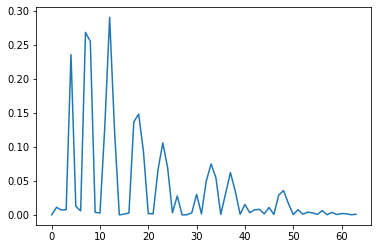

In [91]:
plt.plot(square_to_zigzag(torch.tensor(G_lst[10])))

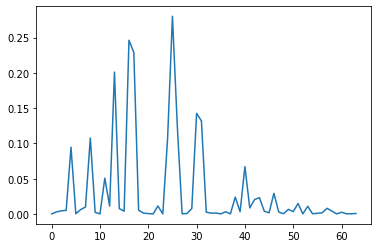

In [92]:
plt.plot(square_to_zigzag(torch.tensor(G_lst[20])))

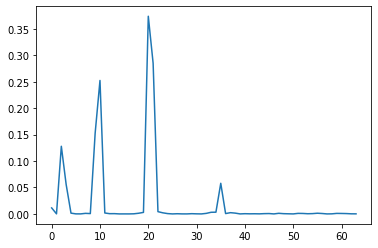

In [93]:
plt.plot(square_to_zigzag(torch.tensor(G_lst[40])))

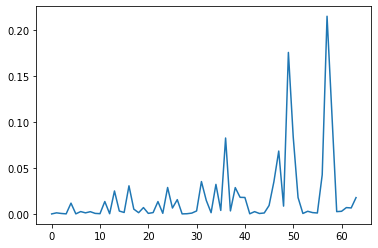

In [94]:
plt.plot(square_to_zigzag(torch.tensor(G_lst[60])))

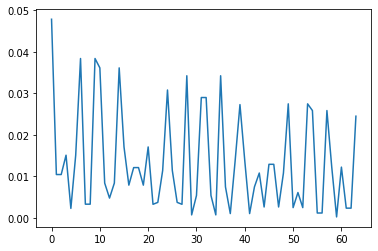

In [73]:
plt.plot(square_to_zigzag(torch.tensor(G_lst[0])))

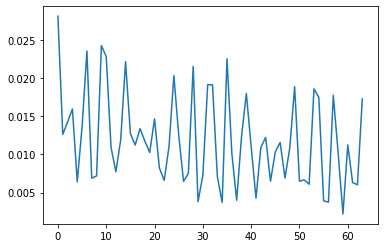

In [74]:
plt.plot(square_to_zigzag(torch.tensor(G_lst[10])))

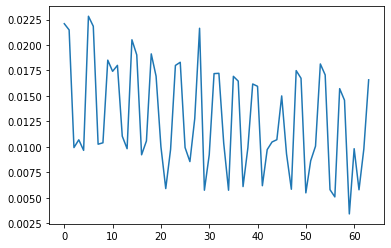

In [75]:
plt.plot(square_to_zigzag(torch.tensor(G_lst[20])))

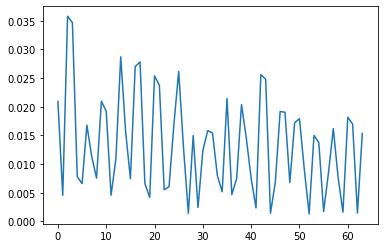

In [76]:
plt.plot(square_to_zigzag(torch.tensor(G_lst[40])))